**Tasks**

**Visual search with k-NN**

Implement a little search engine based on the high-level image representation and k-nearest neighbors

- Fit and tune a k-NN classifier
- Pick an image from the test set and plot its 10 nearest neighbors from the train set

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import os


from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

%matplotlib inline

In [2]:
# get the class label limit
class_limit = 6

# class names
class_names = ["car", "bike", "other", "van", "motorcycle", "truck"]

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

def label_img(number):
    # conversion 
    if number==0 : return 'car'
    #                             
    if number==1 : return 'bike'
    #                             
    if number==2 : return 'other'
    #                             
    if number==3 : return 'van'
    #                             
    if number==4 : return 'motorcycle'
    #                             
    if number==5 : return 'truck'

In [4]:
# Load the numpy .npy file
train_dataset_array = np.load("train_dataset_array.npy")
train_dataset_array_labels = np.load("train_dataset_array_labels.npy")
train_dataset_array_features = np.load("train_features.npy")

print('Train data loaded')

Train data loaded


In [5]:
# Load the numpy .npy file
test_dataset_array = np.load("test_dataset_array.npy")
test_dataset_array_labels = np.load("test_dataset_array_labels.npy")
test_dataset_array_features = np.load("test_features.npy")

print('Test data loaded')

Test data loaded


In [6]:
# Load the numpy .npy file
valid_dataset_array = np.load("valid_dataset_array.npy")
valid_dataset_array_labels = np.load("valid_dataset_array_labels.npy")
valid_dataset_array_features = np.load("valid_features.npy")

print('Validation data loaded')

Validation data loaded


In [7]:
# Create X/y arrays
X_tr = train_dataset_array_features
y_tr = train_dataset_array_labels

print('X_tr:', X_tr.shape, X_tr.dtype)
print('y_tr:', y_tr.shape, y_tr.dtype)

X_tr: (280, 1024) float32
y_tr: (280,) int64


In [8]:
# Create X/y arrays
X_te = test_dataset_array_features
y_te = test_dataset_array_labels

print('X_te:', X_te.shape, X_te.dtype)
print('y_te:', y_te.shape, y_te.dtype)

X_te: (50, 1024) float32
y_te: (50,) int64


In [9]:
# Create X/y arrays
X_val = valid_dataset_array_features
y_val = valid_dataset_array_labels

print('X_val:', X_val.shape, X_val.dtype)
print('y_val:', y_val.shape, y_val.dtype)

X_val: (139, 1024) float32
y_val: (139,) int64


In [10]:
# Convert to float
X_tr = X_tr.astype(np.float)
X_val = X_val.astype(np.float)
X_te = X_te.astype(np.float)

StandardScaler().fit_transform(X_tr)

# Print the new data type
print('dtype:', X_tr.dtype) # float64
# Print the new data type
print('dtype:', X_val.dtype) # float64
# Print the new data type
print('dtype:', X_te.dtype) # float64

dtype: float64
dtype: float64
dtype: float64


We can now create a pipeline object with k-NN. Scikit-learn implements a KNeighborsRegressor and a KNeighborsClassifier estimator. We can set the number of neighbors with their n_neighbors attribute later on.

In [11]:
pipe = Pipeline([
      ('scaler', StandardScaler()),
      ('knn', KNeighborsClassifier())
])
# Fit to train data
pipe.fit(X_tr, y_tr)
# Evaluate on validation and test set
accuracy = pipe.score(X_val, y_val) 
print('Accuracy on the validation set: {:.3f}'.format(accuracy))
accuracy = pipe.score(X_te, y_te) 
print('Accuracy on the test set: {:.3f}'.format(accuracy))

Accuracy on the validation set: 0.849
Accuracy on the test set: 0.840


Let's see if we can improve the results by tuning k. 

In [12]:
# Define a set of reasonable values
k_values = np.arange(1, 21) # 1, 2, 3, .., 20 
weights_functions = ['uniform', 'distance'] 
distance_types = [1, 2] # L1, L2 distances

In [13]:
# Create k-NN classifier
pipe = Pipeline([
    #('scaler', StandardScaler()), # With standardization
    ('scaler', None), # Better performance without standardization!
    ('knn', KNeighborsClassifier(
        algorithm='brute', # Brute-force search
        n_jobs=-1 # As many parallel jobs as possible
    ))
])

# A first grid of parameters - start with a few k values
grid = ParameterGrid({
    'knn__n_neighbors': [10, 20, 30], # k
    'knn__weights': ['uniform', 'distance'], # Weighting function
    'knn__p': [1, 2], # L1 and L2 distance metrics
})

# Print the number of combinations
print('Number of combinations:', len(grid))

Number of combinations: 12


In [14]:
# Save accuracy on test set
test_scores = []

# Enumerate combinations starting from 1
for i, params_dict in enumerate(grid, 1):
    # Print progress
    print('Combination {}/{}'.format(
        i, len(grid) # Total number of combinations
    ))
    
    # Set parameters
    pipe.set_params(**params_dict)

    # Fit a k-NN classifier
    pipe.fit(X_tr, y_tr)

    # Save accuracy on test set
    params_dict['accuracy'] = pipe.score(X_val, y_val)

    # Save result
    test_scores.append(params_dict)

print('done')

Combination 1/12
Combination 2/12
Combination 3/12
Combination 4/12
Combination 5/12
Combination 6/12
Combination 7/12
Combination 8/12
Combination 9/12
Combination 10/12
Combination 11/12
Combination 12/12
done


In [15]:
# Create DataFrame with test scores
scores_df = pd.DataFrame(test_scores) 

# Top five scores
scores_df.sort_values(by='accuracy', ascending=False).head(5)

,accuracy,knn__n_neighbors,knn__p,knn__weights
2,0.863309,10,2,uniform
3,0.863309,10,2,distance
0,0.834532,10,1,uniform
1,0.834532,10,1,distance
6,0.827338,20,2,uniform


In [16]:
# Refine our search
pipe = Pipeline([
    ('scaler', None), # Again, without standardization
    ('knn', KNeighborsClassifier(
        algorithm='brute', # Brute-force search
        p=1, 
        weights='distance', 
        n_jobs=-1 # As many parallel jobs as possible
    ))
])

# Refine the grid
grid = ParameterGrid({
    'knn__n_neighbors': [1, 5, 10, 15, 20] # Best k seems around 10
})

# Grid search
test_scores = []

for i, params_dict in enumerate(grid, 1):
    # Print progress
    print('Combination {}/{}'.format(
        i, len(grid) # Total number of combinations
    ))
    
    # Set parameters
    pipe.set_params(**params_dict)

    # Fit a k-NN classifier
    pipe.fit(X_tr, y_tr)

    # Save accuracy on test set
    params_dict['accuracy'] = pipe.score(X_val, y_val)

    # Save result
    test_scores.append(params_dict)

print('done')

Combination 1/5
Combination 2/5
Combination 3/5
Combination 4/5
Combination 5/5
done


In [17]:
# Create DataFrame with scores
pd.DataFrame(test_scores).sort_values(by='accuracy', ascending=False)

,accuracy,knn__n_neighbors
0,0.870504,1
1,0.848921,5
2,0.834532,10
4,0.812950,20
3,0.805755,15


In [24]:
accuracy_best = pipe.score(X_tr, y_tr)
print ('K-NN accuracy on the train set: {:.3f}'.format(accuracy_best))

K-NN accuracy on the train set: 0.850


The best K seems to be around 5.

In [18]:
accuracy_best = pipe.score(X_val, y_val)
print ('K-NN accuracy on the validation set: {:.3f}'.format(accuracy_best))

K-NN accuracy on the validation set: 0.813


In [19]:
accuracy_best = pipe.score(X_te, y_te)
print ('K-NN accuracy on the test set: {:.3f}'.format(accuracy_best))

K-NN accuracy on the test set: 0.820


In [25]:
pipe.set_params(scaler=None, knn__n_neighbors=5)
pipe.fit(X_tr, y_tr)

accuracy_best = pipe.score(X_val, y_val)
print ('K-NN accuracy on the validation set: {:.3f}'.format(accuracy_best))
accuracy_best = pipe.score(X_te, y_te)
print ('K-NN accuracy on the test set: {:.3f}'.format(accuracy_best))

K-NN accuracy on the validation set: 0.842
K-NN accuracy on the test set: 0.880


In [21]:
random_number = random.randint(0, len(X_te))

# We take a random image from the test set
X_img = X_te[random_number].reshape(1, -1)

from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=10, algorithm='auto').fit(X_tr)
distances, indices = nbrs.kneighbors(X_img)
distances, indices

(array([[23.89831086, 24.09813497, 24.31220776, 24.72834175, 24.75121213,
         24.95746722, 25.01962001, 25.24007053, 25.57380825, 25.66184965]]),
 array([[210, 197, 194, 211, 202, 233, 234, 217, 232, 208]]))

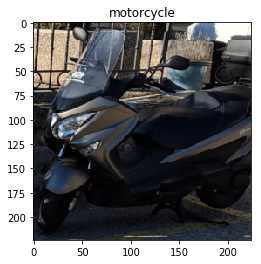

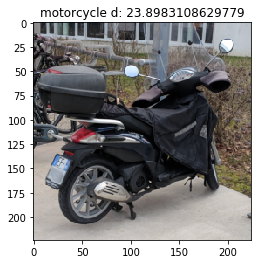

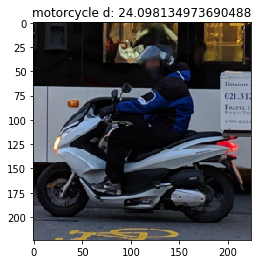

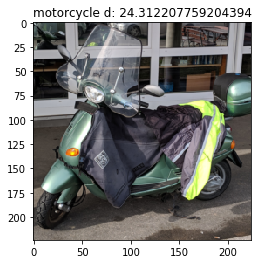

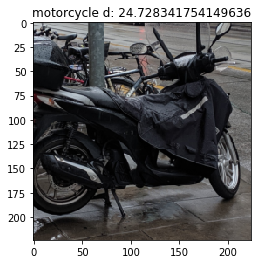

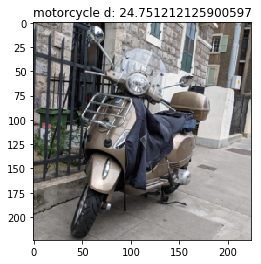

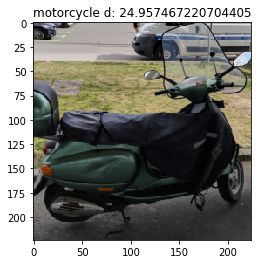

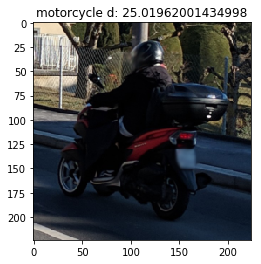

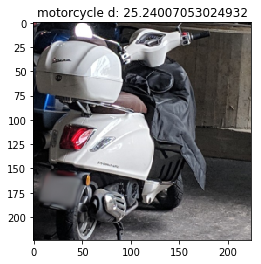

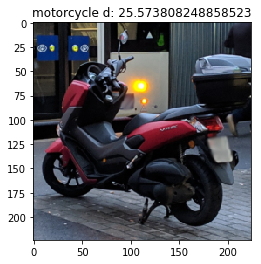

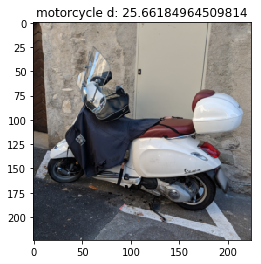

In [22]:
# Plotting the original image
flat_img = test_dataset_array[random_number]
plt.imshow(flat_img)
plt.title(label_img(test_dataset_array_labels[random_number]))
plt.show()

d = distances[0]
idx = 0
# Plotting its 10 nearest neighbors from the train set
for i in indices:
    for j in i:
        flat_img = train_dataset_array[j]
        plt.imshow(flat_img)
        plt.title(label_img(train_dataset_array_labels[j])+" d: "+str(d[idx]))
        plt.show()
        idx += 1